<img src="NotebookAddons/UNAVCO-Banner.jpg" width="100%" />
<font face="Calibri">
<br>
<font size="6"> <b> Volcano Source Modeling Using InSAR </b> </font>

<br>
<font size="4"> <b> Franz J Meyer; University of Alaska Fairbanks </b> <br>

<font size="3"> This lab will introduce you to the intersection between Radar Remote Sensing and Inverse Modeling. Radar Remote Sensing can provide you with geodetic observations of surface displacement. Inverse Modeling helps you understand the physical causes behind an observed displacement. 
    
To illuminate the handoff from geodesy to geophysics, this lab will show how to use InSAR observations to determine the most likely parameters of a volcanic magma source underneath Okmok volcano, Alaska. You will use a Mogi source model to describe the physics behind displacement at Okmok. <br><br>

<b>This Lab will introduce the following data analysis concepts:</b>
- A Mogi Source Model describing volcanic source geometry and physics
- How to use the "grid search" method to perform a pseudo-inversion of a Mogi source model 
- How to solve for the best fitting source parameters using modeling with InSAR data
</font>

<hr>
<font face="Calibri" size="5" color='rgba(200,0,0,0.2)'> <b>Important Notes about Binder</b> </font>
<br><br>
<font face="Calibri" size="3"> <b>The Binder server will automatically shutdown when left idle for more than 10 minutes. Your notebook edits will be lost when this happens. You will need to relaunch the binder to continue working in a fresh copy of the notebook.</b></font>
    <br><br>
    <font face="Calibri" size="4"><b>How to Save your Notebook Edits</b></font>
        <br><br>
<font face="Calibri" size="3"><b>The Easy Way</b>
    <br>
Click on the Jupyter logo at the top left of the screen to access the file manager. Download the notebook, then upload and run it the next time you restart the server.
    <br><br>
<b>The Better, More Complicated Way</b>
    <br>
This solution requires some knowledge of git. Fork the <a href="https://github.com/asfadmin/asf-jupyter-notebooks" target="_blank">asf-jupyter-notebook repository</a> and update the url for the Binder launch button to the url of your fork. The url to edit can be found in the first line of the README.md file for this branch. Once you have your own fork, push any notebook changes to it prior to shutting down the server or allowing it to time out.  </font>
<br><br>
</font>
<hr>

# Importing Relevant Python Packages

<font face="Calibri" size="3"> First step in any notebook is to import the required Python libraries into the Jupyter environment. In this notebooks we use the following scientific libraries:
<ol type="1">
    <li> <b><a href="http://www.numpy.org/" target="_blank">NumPy</a></b> is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays. </li>
    <li> <b><a href="https://matplotlib.org/index.html" target="_blank">Matplotlib</a></b> is a low-level library for creating two-dimensional diagrams and graphs. With its help, you can build diverse charts, from histograms and scatterplots to non-Cartesian coordinates graphs. </li>
</ol>
<br>
<font face="Calibri" size="3">The first step is to <b>import all required python modules:</b></font>

In [1]:
import copy
import os # for chdir, getcwd, path.basename, path.exists


import matplotlib.pylab as plt # for add_subplot, cm.jet, colorbar, figure, grid, imshow, rcParams.update, savefig,
                               # set_bad, set_clim, set_title, set_xlabel, set_ylabel
import numpy as np # for arange, arctan, concatenate, cos, fromfile, isnan, ma.masked_value, min, pi, power, reshape,
                   # sqrt, square, sin, sum, tile, transpose, where, zeros     

<font face="Calibri" size="3"><b>set up matplotlib plotting</b> inside the notebook:</font>

In [2]:
%matplotlib inline

<hr>

# Introduction to the Study Site: Okmok Volcano, Alaska

<font face="Calibri" size="3"><img style="padding: 7px" src="NotebookAddons/Lab6-OkmokdefoGPS.JPG" width="550" align="right" /> Okmok is one of the more active volcanoes in Alaska’s Aleutian Chain. Its last (confirmed) eruption was in the summer of 2008. Okmok is interesting from an InSAR perspective as it inflates and deflates heavily as magma moves around in its magmatic source located roughly 2.5 km underneath the surface. To learn more about Okmok volcano and its eruptive history, please visit the very informative site of the <a href="https://avo.alaska.edu/volcanoes/activity.php?volcname=Okmok&eruptionid=604&page=basic" target="_blank">Alaska Volcano Observatory</a>.

This lab uses a pair of C-band ERS-2 SAR images acquired on Aug 18, 2000 and Jul 19, 2002 to analyze the properties of a volcanic source that was responsible for an inflation of Okmok volcano of more than 3 cm near its summit. The figure to the right shows the Okmok surface displacement as measured by GPS data from field campaigns conducted in 2000 and 2002. The plots show that the displacement measured at the site is consistent with that created by an inflating point (Mogi) source.<br> 

<b>The primary goal of the problem set is to estimate values for four unknown model parameters describing a source process beneath a volcano.</b> The lab uses real InSAR data from Okmok volcano, so you should get some sense for how remote sensing can be used to infer physical processes at volcanoes. We will assume that the source can be modeled as an inflating point source (a so-called Mogi source) and will use a grid-search method to find the source model parameters (3D source location and volume of magma influx) that best describe our InSAR-observed surface displacement.
</font>
</font>
<hr>

# Downloading and Visualizing the InSAR Data

## Download Data from AWS S3 Storage Bucket and Prep for Further Processing

<font face="Calibri" size="3">We are using a pre-calculated displacement map created from C-band ERS-2 SAR images acquired on Aug 18, 2000 and Jul 19, 2002. We will pull the displacement map from an <b>Amazon Web Services (AWS) S3 storage bucket:</b> </font>

<font face="Calibri" size="3"><b>Create and move to a directory in which to store our Lab 2 files:"</font>

In [3]:
path = "/home/jovyan/Mon_lab2"
if not os.path.exists(path):
    os.mkdir(path)
os.chdir(path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/jovyan/Mon_lab2


<font face="Calibri" size="3"><b>Download the displacement map from the AWS-S3 bucket:</b></font>

In [4]:
displacement_map_path = 's3://asf-jupyter-data/E451_20000818_20020719.unw'
displacement_map = os.path.basename(displacement_map_path)
!aws --no-sign-request --region us-east-1 s3 cp $displacement_map_path $displacement_map

download: s3://asf-jupyter-data/E451_20000818_20020719.unw to ./E451_20000818_20020719.unw


<font face="Calibri" size="3"><b>Define some variables:</b></font>

In [5]:
sample = 1100
line = 980
posting = 40.0
half_wave = 28.3

<font face="Calibri" size="3"><b>Read the dataset into the notebook</b>, storing our InSAR data in the variable <i>"observed_displacement_map"</i>: </font>

In [6]:
if os.path.exists(displacement_map):
    with open (displacement_map, 'rb') as f:    
        coh = np.fromfile(f, dtype='>f', count=-1)
    observed_displacement_map = np.reshape(coh, (line, sample))

<font face="Calibri" size="3">Now we scale the measured and unwrapped InSAR phase into surface displacement in *cm* units and replace all ```nans``` with 0</font>

In [7]:
observed_displacement_map = observed_displacement_map*half_wave/2.0/np.pi
where_are_NaNs = np.isnan(observed_displacement_map)
observed_displacement_map[where_are_NaNs] = 0

<font face="Calibri" size="3"> <b>Create a mask</b> that removes invalid samples (low coherence) from the displacement map: </font>

In [8]:
observed_displacement_map_m = np.ma.masked_where(observed_displacement_map==0, observed_displacement_map)

<hr>

## Visualize The Surface Displacement Map

<font face="Calibri" size="3"> We will visualize the displacement map both in units of [cm] and as a rewrapped interferogram.
<br><br>
<b>Write a function that calculates the bounding box.</b></font>

In [9]:
def extents(vector_component):
        delta = vector_component[1] - vector_component[0]
        return [vector_component[0] - delta/2, vector_component[-1] + delta/2]

<font face="Calibri" size="3"><b>Create a directory in which to store the plots we are about to make, and move into it:</b></font> 

In [10]:
os.chdir(path)
product_path = 'plots'
if not os.path.exists(product_path):
    os.mkdir(product_path)
if os.path.exists(product_path) and os.getcwd() != f"{path}/{product_path}":
    os.chdir(product_path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/jovyan/Mon_lab2/plots


<font face="Calibri" size="3"><b>Write a plotting function</b>:</font>

In [11]:
def plot_model(infile, line, sample, posting, output_filename=None, dpi=72):
    # Calculate the bounding box
    extent_xvec = extents((np.arange(1, sample*posting, posting)) / 1000)
    extent_yvec = extents((np.arange(1, line*posting, posting)) / 1000)
    extent_xy = extent_xvec + extent_yvec
    
    plt.rcParams.update({'font.size': 14})
    inwrapped = (infile/10 + np.pi) % (2*np.pi) - np.pi
    cmap = copy.copy(plt.cm.get_cmap("jet"))
    cmap.set_bad('white', 1.)
    
    # Plot displacement
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    im = ax1.imshow(infile, interpolation='nearest', cmap=cmap, extent=extent_xy, origin='upper')
    cbar = ax1.figure.colorbar(im, ax=ax1, orientation='horizontal')
    ax1.set_title("Displacement in look direction [mm]")
    ax1.set_xlabel("Easting [km]")
    ax1.set_ylabel("Northing [km]")
    plt.grid()
    
    # Plot interferogram
    im.set_clim(-30, 30)
    ax2 = fig.add_subplot(1, 2, 2)
    im = ax2.imshow(inwrapped, interpolation='nearest', cmap=cmap, extent=extent_xy, origin='upper')
    cbar = ax2.figure.colorbar(im, ax=ax2, orientation='horizontal')
    ax2.set_title("Interferogram phase [rad]")
    ax2.set_xlabel("Easting [km]")
    ax2.set_ylabel("Northing [km]")
    plt.grid()
    
    if output_filename:
        plt.savefig(output_filename, dpi=dpi)

<font face="Calibri" size="3">Call plot_model() to <b>plot our observed displacement map:</b> </font>

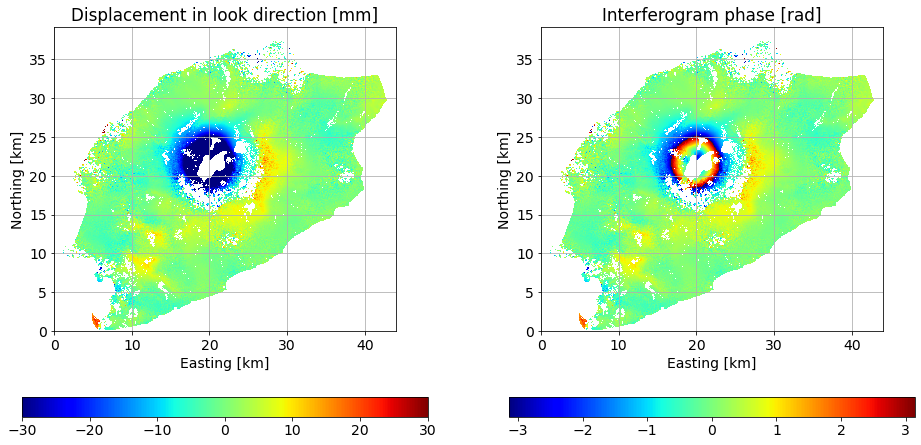

In [12]:
plot_model(observed_displacement_map_m, line, sample, posting, output_filename='Okmok-inflation-observation.png', dpi=200)

<hr>

# The Mogi Source Forward Model for InSAR Observations

## The Mogi Equation

<font face="Calibri" size="3">The Mogi model provides the 3D ground displacement, $u(x,y,z)$, due to an inflating source at location $(x_s,y_s,z_s)$ with volume change $V$:

\begin{equation}
u(x,y,z)=\frac{1}{\pi}(1-\nu)\cdot V\Big(\frac{x-x_s}{r(x,y,z)^3},\frac{y-y_s}{r(x,y,z)^3},\frac{z-z_s}{r(x,y,z)^3}\Big)
\end{equation}
<br>
\begin{equation}
r(x,y,z)=\sqrt{(x-x_s)^2+(y-y_s)^2+(z-z_s)^2}
\end{equation}

where $r$ is the distance from the Mogi source to $(x,y,z)$, and $\nu$ is the Poisson's ratio of the halfspace. The Poisson ratio describes how rocks react when put under stress (e.g., pressure). It is affected by temperature, the quantity of liquid to solid, and the composition of the soil material. <b>In our problem, we will assume that $\nu$ is fixed</b>. 
 </font>

## Projecting Mogi Displacement to InSAR Line-of-Sight

<font face="Calibri" size="3">In our example, the $x$-axis points east, $y$ points north, and $z$ points up. However, in the code the input values for $z$ are assumed to be depth, such that the Mogi source is at depth $z_s > 0$. The observed interferogram is already corrected for the effect of topography, so the observations can be considered to be at $z = 0$.
    
<img style="padding: 7px" src="NotebookAddons/Lab6-LOSprojection.JPG" width="650" align="center" />
The satellite “sees” a projection of the 3D ground displacement, $u$, onto the look vector, $\hat{L}$, which points from the satellite to the target. Therefore, we are actually interested in the (signed magnitude of the) projection of $u$ onto $\hat{L}$ (right). This is given by

\begin{array}{lcl} proj_{\hat{L}}u & = & (u^T\hat{L})\hat{L} \\ u^T\hat{L} & = & u \cdot \hat{L} = |u||\hat{L}|cos(\alpha) = |u|cos(\alpha) \\ & = & u_x\hat{L}_x+ u_y\hat{L}_y + u_z\hat{L}_z \end{array}

where the look vector is given by $\hat{L}=(sin(l) \cdot cos(t), -sin(l) \cdot sin(t), -cos(l))$, where $l$ is the look angle measured from the nadir direction and $t$ is the satellite track angle measured clockwise from geographic north. All vectors are represented in an east-north-up basis.

Our forward model takes a Mogi source, $(x_s,y_s,z_s,V)$, and computes the look displacement at any given $(x, y, z)$ point. If we represent the <i>i</i>th point on our surface grid by $x_i = (x_i,y_i,z_i)$ the the displacement vector is $u_i = u(x_i, y_i, z_i)$, and the look displacement is

\begin{equation}
d_i = u_i \cdot \hat{L}
\end{equation}

</font>


## Defining the Mogi Forward Model

<font face="Calibri" size="3">We can now represent the Mogi <i>forward problem</i> as 

\begin{equation}
g(m) = d
\end{equation}

where $g(·)$ describes the forward model in the very first equation in this notebook, $m$ is the (unknown) Mogi model, and $d$ is the predicted interferogram. The following code cells calculate the Mogi forward model according to the equations given above:
</font>

<font face="Calibri" size="3"><b>Write a function to calculate a forward model for a Mogi source.</b> </font>

In [13]:
def calc_forward_model_mogi(n1, e1, depth, delta_volume, northing, easting, plook):
    
    # This geophysical coefficient is needed to describe how pressure relates to volume change
    displacement_coefficient = (1e6*delta_volume*3)/(np.pi*4)
    
    # Calculating the horizontal distance from every point in the displacement map to the x/y source location
    d_mat = np.sqrt(np.square(northing-n1) + np.square(easting-e1))
    
    # denominator of displacement field for mogi source
    tmp_hyp = np.power(np.square(d_mat) + np.square(depth),1.5)
    
    # horizontal displacement
    horizontal_displacement = displacement_coefficient * d_mat / tmp_hyp
    
    # vertical displacement
    vertical_displacement = displacement_coefficient * depth / tmp_hyp
    
    # azimuthal angle
    azimuth = np.arctan2((easting-e1), (northing-n1))
    
    # compute north and east displacement from horizontal displacement and azimuth angle
    east_displacement = np.sin(azimuth) * horizontal_displacement
    north_displacement = np.cos(azimuth) * horizontal_displacement
    
    # project displacement field onto look vector
    temp = np.concatenate((east_displacement, north_displacement, vertical_displacement), axis=1)
    delta_range = temp.dot(np.transpose([plook]))
    delta_range = -1.0 * delta_range
    return delta_range

<font face="Calibri" size="3"><b>Write a function to create simulated displacement data based on Mogi Source Model parameters:</b> </font>

In [14]:
def displacement_data_from_mogi(x, y, z, volume, iplot, imask):
    # Organizing model parameters
    bvc = np.array([x, y, z, volume, 0, 0, 0, 0], dtype=object)
    bvc = np.transpose(bvc)
    
    # Setting acquisition parameters
    track =  -13.3*np.pi / 180.0
    look  = 23.0*np.pi / 180.0
    plook = [-np.sin(look)*np.cos(track), np.sin(look)*np.sin(track), np.cos(look)]
    
    # Defining easting and northing vectors
    northing = np.arange(0, (line)*posting, posting) / 1000
    easting = np.arange(0, (sample)*posting, posting) / 1000
    northing_mat = np.tile(northing, (sample, 1))
    easting_mat = np.transpose(np.tile(easting, (line, 1)))
    northing_vec = np.reshape(northing_mat, (line*sample, 1))
    easting_vec = np.reshape(easting_mat, (line*sample, 1))
    
    # Handing coordinates and model parameters over to the rngchg_mogi function
    calc_range = calc_forward_model_mogi(bvc[1], bvc[0], bvc[2], bvc[3], northing_vec, easting_vec, plook)
    
    # Reshaping surface displacement data derived via calc_forward_model_mogi()
    surface_displacement = np.reshape(calc_range, (sample,line))
    
    # return rotated surface displacement
    return np.transpose(np.fliplr(surface_displacement))

<hr>

## Plotting The Mogi Forward Model

<font face="Calibri" size="3">The cell below plots several Mogi forward models by varying some of the four main Mogi modeling parameters $(x_s,y_s,z_s,V)$.
    
The examples below fix the <i>depth</i> parameter to $z_s = 2.58 km$ and the <i>volume</i> change parameter to $volume = 0.0034 km^3$. We then vary the <i>easting</i> and <i>northing</i> parameters $x_s$ and $y_s$ to demonstrate how the model predictions vary when model parameters are changed.</font>
<br><br>
<font face="Calibri" size="3"><b>Run the first example:</b> </font>

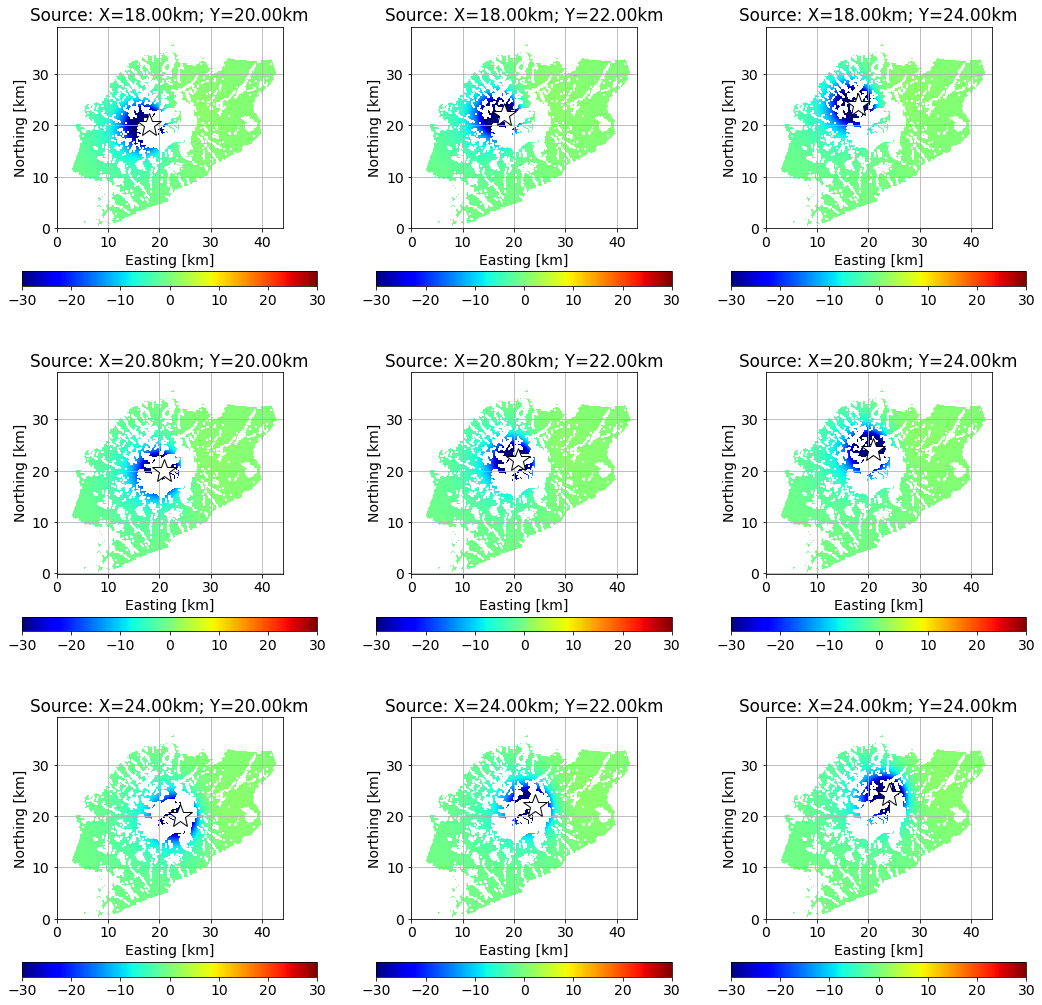

In [15]:
plt.rcParams.update({'font.size': 14})
extent_x = extents((np.arange(1, sample*posting, posting))/1000)
extent_y = extents((np.arange(1, line*posting, posting))/1000)
extent_xy = extent_x + extent_y
xs = np.arange(18, 24.2, 0.4)
ys = np.arange(20, 24.2, 0.4)

zs = 2.58;              # <--- Change these variables to do the exercise described below the figure
volume = 0.0034;        # <--- Change these variables to do the exercise described below the figure
xa = [0, 7, 15]
ya = [0 ,5, 10]

fig = plt.figure(figsize=(18, 18))
cmap = copy.copy(plt.cm.get_cmap("jet"))
subplot_index = 1

for k in xa:
    for l in ya: 
        ax = fig.add_subplot(3, 3, subplot_index)
        predicted_displacement_map = displacement_data_from_mogi(xs[k], ys[l], zs, volume, 0, 0)
        predicted_displacement_map_m = np.ma.masked_where(observed_displacement_map==0, predicted_displacement_map)
        im = ax.imshow(predicted_displacement_map_m, cmap=cmap, extent=extent_xy)
        cbar = ax.figure.colorbar(im, ax=ax, orientation='horizontal')
        plt.grid()
        im.set_clim(-30, 30)
        ax.plot(xs[k],ys[l], 'k*', markersize=25, markerfacecolor='w')
        ax.set_title('Source: X=%4.2fkm; Y=%4.2fkm' % (xs[k], ys[l]))
        ax.set_xlabel("Easting [km]")
        ax.set_ylabel("Northing [km]")
        subplot_index += 1
        
plt.savefig('Model-samples-3by3.png', dpi=200, transparent='false')

<br>
<hr>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>SUGGESTED EXERCISE</u>:  </font> Experiment with the Mogi Forward Model </b>  </font>

<font face="Calibri" size="3"> To get a feeling for the Mogi forward model, please run the following forward model experiments using the Python Function <i>displacement_data_from_mogi</i> and plot the results (using the code cell above):

<ol type="a">
<li>Run a reference simulation using the code cell above by changing the model parameters for source depth $x_s$ and volume change $V$ to the following values: $z_{s1} = 2.5 km$; $V_1 = 0.01 km^3$. The script will visualize the resulting simulated surface displacement maps.</li>
<br>
<li>Change the depth of the source by a factor of three ($z_{s2} = 7.5 km$) while leaving the other model parameters unchanged. Run the code cell above to visualize the results. How have the plots changed compared to the reference run? Do the changes make sense to you?</li>
<br>
<li>Now change the source volume by a factor of three ($V_2 = 0.03 km^3$ – also reset source depth to $z_{s1} = 2.5 km$). Visualize the results and compare them to the reference run.</li>
<br>
<li>Finally change both source volume and depth by a factor of three ($z_{s2} = 7.5 km$ and $V_2 = 0.03 km^3$). Compare this result to the results of experiments 1–3.</li>
</ol>
These experiments should provide you with a bit of a feeling for how different source configurations result in different surface deformation magnitudes and patterns.
</font>
</div>

<hr>

# Solving the Inverse Model

<font face="Calibri" size="3"> The inverse problem seeks to determine the optimal parameters $(\hat{x_s},\hat{y_s},\hat{z_s},\hat{V})$ of the Mogi model $m$ by minimizing the <i>misfit</i> between predictions, $g(m)$, and observations $d^{obs}$ according to
    
\begin{equation}
\sum{\Big[g(m) - d^{obs}\Big]^2}
\end{equation}

This equation describes misfit using the <i>method of least-squares</i>, a standard approach to approximate the solution of an overdetermined equation system. We will use a <i>grid-search</i> approach to find the set of model parameters that minimize the the misfit function. The approach is composed of the following processing steps: 
<ol>
<li>Loop through the mogi model parameters,</li> 
<li>Calculate the forward model for each set of parameters,</li> 
<li>Calculate the misfit $\sum{[g(m) - d^{obs}]^2}$, and</li> 
<li>Find the parameter set that minimizes this misfit.</li>
</ol>
</font>

## Experimenting with Misfit

<font face="Calibri" size="3">Let's <b>look at the misfit $\sum{[g(m) - d^{obs}]^2}$ for a number of different model parameter sets $(x_s,y_s,z_s,V)$:</b> 

</font>

In [ ]:
plt.rcParams.update({'font.size': 14})
extent_x = extents((np.arange(1, sample*posting, posting))/1000)
extent_y = extents((np.arange(1, line*posting, posting))/1000)
extent_xy = extent_x + extent_y
xs = np.arange(18, 24.2, 0.4)
ys = np.arange(20, 24.2, 0.4)

zs = 2.58;
volume = 0.0034;
xa = [0, 7, 15]
ya = [0 ,5, 10]

fig = plt.figure(figsize=(18, 18))
cmap = copy.copy(plt.cm.get_cmap("jet"))
subplot_index = 1

for k in xa:
    for l in ya: 
        ax = fig.add_subplot(3, 3, subplot_index)
        predicted_displacement_map = displacement_data_from_mogi(xs[k], ys[l], zs, volume, 0, 0)
        predicted_displacement_map_m = np.ma.masked_where(observed_displacement_map==0, predicted_displacement_map)
        im = ax.imshow(observed_displacement_map_m-predicted_displacement_map_m, cmap=cmap, extent=extent_xy)
        cbar = ax.figure.colorbar(im, ax=ax, orientation='horizontal')
        plt.grid()
        im.set_clim(-30, 30)
        ax.plot(xs[k], ys[l], 'k*', markersize=25, markerfacecolor='w')
        ax.set_title('Source: X=%4.2fkm; Y=%4.2fkm' % (xs[k], ys[l]))
        ax.set_xlabel("Easting [km]")
        ax.set_ylabel("Northing [km]")
        subplot_index += 1
plt.savefig('Misfit-samples-3by3.png', dpi=200, transparent='false')

<br>
<hr>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>Think about these Plots</u>:  </font> Analyze the Misfit Plots </b>  </font>

<font face="Calibri" size="3"> Each of the plots above show the difference (misfit) between the model-simulated surface deformation and the InSAR-measured surface deformation. A perfect fitting model would result in a plot that has the color "green" for all pixels, indicating a misfit of 0. Looking at the plots, try to answer the following questions for yourself:

<ol type="a">
<li>Analyze the misfit plots for the 9 different forward model configurations that were simulated. Does the change of the plots make sense to you?</li>
<br>
<li>Which of the plots shows the smallest misfit? What are the $X$ and $Y$ model parameters for this "best" fitting experiment?</li>
</ol>
</font>
</div>

<hr>

## Running Grid-Search to find the Best Fitting Mogi Source Location Parameters

<font face="Calibri" size="3">The following code cell runs a grid-search approach to find the best fitting Mogi source parameters for the 2000-2002 displacement event at Okmok. To keep things simple, we will fix the depth $z_s$ and volume change $V$ parameters close to their "true" values and search only for the correct east/north source location ($x_s,y_s$).</font>
<br><br>
<font face="Calibri" size="3"><b>Write a script using the grid-search approach in Python:</b></font>

In [ ]:
# FIX Z AND dV, SEARCH OVER X AND Y

# Setting up search parameters
xs = np.arange(19, 22.2, 0.2)
ys = np.arange(21, 23.2, 0.2)
zs = 2.58;
volume = 0.0034;

nx = xs.size
ny = ys.size
ng = nx * ny;

print(f"fixed z = {zs}km, dV = {volume}, searching over (x,y)")

misfit = np.zeros((nx, ny))
subplot_index = 0

# Commence grid-search for best model parameters
for k, xv in enumerate(xs):
    for l, yv in enumerate(ys):
        subplot_index += 1
        predicted_displacement_map = displacement_data_from_mogi(xs[k], ys[l], zs, volume, 0, 0)
        predicted_displacement_map_m = np.ma.masked_where(observed_displacement_map==0, predicted_displacement_map)
        misfit[k,l] = np.sum(np.square(observed_displacement_map_m - predicted_displacement_map_m))
    print(f"Source {subplot_index:3d}/{ng:3d} is x = {xs[k]:.2f} km, y = {ys[l]:.2f} km")

# Searching for the minimum in the misfit matrix
mmf = np.where(misfit == np.min(misfit))
print(f"\n----------------------------------------------------------------")
print('Best fitting Mogi Source located at: X = %5.2f km; Y = %5.2f km' % (xs[mmf[0]], ys[mmf[1]]))
print(f"----------------------------------------------------------------")

<hr>

## Plot and Inspect the Misfit Function

<font face="Calibri" size="3">The code cell below plots the misfit function ($\sum{[g(m) - d^{obs}]^2}$) describing the fit of different Mogi source parameterizations to the observed InSAR data. You should notice a clear minimum in the misfit plot at the location of the best fitting source location estimated above. 
    
You may notice that, even for the best fitting solution, the misfit does not become zero. This could be due to other signals in the InSAR data (e.g., atmospheric effects or residual topography). Alternatively, it could also indicate that the observed displacement doesn't fully comply with Mogi theory. 
</font>
<br><br>
<font face="Calibri" size="3"><b>Plot the misfit function ($\sum{[g(m) - d^{obs}]^2}$):</b></font>

In [ ]:
plt.rcParams.update({'font.size': 18})
extent_xy = extents(xs) + extents(ys)
fig = plt.figure(figsize=(10, 10))
cmap = copy.copy(plt.cm.get_cmap("jet"))
ax1 = fig.add_subplot(1, 1 ,1)
im = ax1.imshow(np.transpose(misfit), origin='lower', cmap=cmap, extent=extent_xy)
# USE THIS COMMAND TO CHANGE COLOR SCALING: im.set_clim(-30, 30)
ax1.set_aspect('auto')
cbar = ax1.figure.colorbar(im, ax=ax1, orientation='horizontal')
ax1.plot(xs[mmf[0]], ys[mmf[1]], 'k*', markersize=25, markerfacecolor='w')
ax1.set_title("Misfit Function for Mogi-Source Approximation")
ax1.set_xlabel("Easting [km]")
ax1.set_ylabel("Northing [km]")
plt.savefig('Misfit-function.png', dpi=200, transparent='false')

<hr>

## Plot Best-Fitting Mogi Forward Model and Compare to Observations

<font face="Calibri" size="3">With the best-fitting model parameters defined, you can now analyze how well the model fits the InSAR-observed surface displacement. The best way to do that is to look at both the observed and predicted displacement maps and compare their spatial patterns. Additionally, we will also plot the residuals (<i>observed_displacement_map</i> - <i>observed_displacement_map</i>) to determine if there are additional signals in the data that are not modeled using Mogi theory. 
</font>
<br><br>
<font face="Calibri" size="3"><b>Compare the observed and predicted displacement maps:</b></font>

In [ ]:
# Calculate predicted displacement map for best-fitting Mogi parameters:
predicted_displacement_map = displacement_data_from_mogi(xs[mmf[0]], ys[mmf[1]], zs, volume, 0, 0)

# Mask the predicted displacement map to remove pixels incoherent in the observations:
predicted_displacement_map_m = np.ma.masked_where(observed_displacement_map==0, predicted_displacement_map)

# Plot observed displacement map
plot_model(observed_displacement_map_m, line, sample, posting)

# Plot simulated displacement map
plot_model(predicted_displacement_map_m, line, sample, posting)

plt.savefig('BestFittingMogiDefo.png', dpi=200, transparent='false')

# Plot simulated displacement map without mask applied
plot_model(predicted_displacement_map, line, sample, posting)

<font face="Calibri" size="3"><b>Determine if there are additional signals in the data that are not modeled using Mogi theory:</b></font>

In [ ]:
# Plot residual between observed and predicted displacement maps
plot_model(observed_displacement_map_m-predicted_displacement_map_m, line, sample, posting)
plt.savefig('Residuals-ObsMinusMogi.png', dpi=200, transparent='false')

<hr>

# Grid-Search for the Best Fitting Mogi Depth and Volume Parameters 

<font face="Calibri" size="3"> For this second grid-search run, we now switch out the model parameters we are trying to estimate. We will assume that the lateral location of the Mogi source is now fixed to the values we just estimated ($\hat{x}_s = 20.6 km$; $\hat{y}_s = 21.8 km$). 

<u>To perform a grid search for the best fitting model parameters $\hat{z}_s$ and $\hat{V}$ this exercise, we will complete the following steps</u>:

<ol>
<br>
<li>Using the previous grid-search script as a template, we <b>create a new grid-search script to search for the best fitting source model depth ($z_s$) and volume change ($V$)</b>.</li>
<br>
<li>Then we will create a plot of the misfit function and provide the best-fitting values for $\hat{z}_s$ and $\hat{V}$.</li>
</ol>
</font>

<hr>
<font face="Calibri" size="3">Below is the grid-search script <b>we will run to find the best fitting model parameters source depth ($\hat{z}_s$) and volume change ($\hat{V}$) parameters of the source model</b>. Note the similarity to the previously used script.</font>

In [ ]:
# Setting up search parameters
xs = 20.6 # [km]
ys = 21.8 # [km]
zs = np.arange(1.3, 4.8, 0.2);
V = np.arange(0.0005, 0.006, 0.00025);
nz = zs.size
nV = V.size
ng = nz*nV;
print('fixed x = ',xs,' km, y = ',ys, ' km, searching over (zs, V)')
misfit=np.zeros((nz,nV))
kk = 0
# Commence grid-search for best model parameters
for k, zv in enumerate(zs):
    for l, Vv in enumerate(V):
        kk = kk+1
        predicted_displacement_map = displacement_data_from_mogi(xs, ys, zs[k], V[l], 0, 0)
        predicted_displacement_map_m = np.ma.masked_where(observed_displacement_map==0, predicted_displacement_map)
        misfit[k,l] = np.sum(np.square(observed_displacement_map_m - predicted_displacement_map_m))
    print('Source %3d/%3d is zs = %4.2f km, V = %0.4f km^3' % (kk, ng, zs[k], V[l]))
# Searching for the minimum in the misfit matrix
mmf = np.where(misfit == np.min(misfit))
print('')
print('-----------------------------------------------------------------')
print('Best fitting Mogi Source located at: Z = %5.2f km; V = %.4f km^3' % (zs[mmf[0]], V[mmf[1]]))
print('-----------------------------------------------------------------')

<font face="Calibri" size="3">Now we can <b>plot the $\hat{z}_s$ vs $\hat{V}$ misfit function</b>.</font>

In [ ]:
def extents(f):
    delta = f[1] - f[0]
    return [f[0] - delta/2, f[-1] + delta/2]
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(10, 10))
vmin = np.nanpercentile(misfit, 1)
vmax = np.nanpercentile(misfit, 95)
im = ax.imshow(misfit, origin='lower', cmap='jet', extent=extents(V) + extents(zs), vmin=vmin, vmax=vmax)
cbar = ax.figure.colorbar(im, ax=ax, orientation='horizontal')
ax.plot(V[mmf[1]], zs[mmf[0]], 'k*', markersize=25, markerfacecolor='w')
ax.set_title('Misfit Function for Mogi-Source Approximation')
ax.set_aspect('auto')
ax.set_xlabel('$V$ (km$^3$)')
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('$z_\mathrm{s}$ (km)')
plt.savefig('Misfit-function_depth_volume.png', dpi=200)

<br>
<hr>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>Compare the two Misfit Plots</u>:</font></b> 
    
<font face="Calibri" size="3">We have now calculated two different misfit functions in the lab. One describing misfit for a $(x_s$ vs. $y_s)$ search and one for a $(z_s$ vs. $V_s)$ search. The two misfit functions have significantly different shape.

The $(x_s$ vs. $y_s)$ misfit plot from earlier showed a symetric and circular shape. In contrast, the $(z_s$ vs. $V_s)$ plot shows a strikingly elongated shape with a visible "trough" oriented in a diagonal direction. 
    
Think about what may cause these differences.
</font>
</div>

# Version Log

<font face="Calibri" size="2"> <i>UNAVCOInSAR-Monday-HW2.ipynb - Version 1.1 - Franz J Meyer, UAF - July 2020 </i>
</font>